In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import LoadDataset

In [3]:
IMG_WIDTH = 64 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 3 # RGB files

In [21]:
DATSET_SIZE = 100
NUM_LABELS = 2

In [22]:
data = LoadDataset.getFixedNumDigistsDataSet(DATSET_SIZE, NUM_LABELS)
DATSET_SIZE = data[0]
imgs = data[1]
labels = data[2]

[6 8]


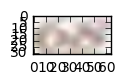

In [23]:
#print (imgs.shape)
import copy
plt.rcParams['figure.figsize'] = (1.0,1.0)
print (labels[10])
img = copy.copy(imgs[10])
#print (img)
#img[img[:,:,:] > 125] = 1
#img[img[:,:,:] <= 125] = 0
plt.imshow(img)
#print (imgs[9].shape)

In [24]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [25]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [26]:
# Generate validation set
ratio = 0.8 # Train/Test set
randIdx = np.random.random(DATSET_SIZE) <= ratio
print (randIdx)
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 11) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 11) for idx in range(Y_test.shape[1])] 
del X, Y # release some space

[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True False  True  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True False False  True False  True  True  True False False  True  True
  True  True  True  True  True False  True  True]


In [27]:
#print (np.array(Y_train).shape)

In [28]:
# Building convolutional network
network = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)

# Training heads
allHeads = []
for idx in range(NUM_LABELS):
    fc = fully_connected(network, 128, activation='tanh')
    fc = dropout(fc, 0.8)
    softmax = fully_connected(fc, 11, activation='softmax')
    networkOut = regression(softmax, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target' + str(idx))
    allHeads.append(networkOut)

network = tflearn.merge(allHeads, mode='elemwise_sum')

In [29]:
model = tflearn.DNN(network, tensorboard_verbose=1)
feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
model.fit({'input': X_train}, feedTrainDict, 
          validation_set= (X_test, feedTestList), n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_mnist')

IndexError: list index out of range